## Glucose study case ##

In [43]:
# Modules
import pandas as pd
import numpy as np
from datetime import datetime
import yaml
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.seanaonal import seasonal_decompose

# for plotting
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.layouts import column
from bokeh.models import (ColumnDataSource, RangeTool, Legend, HoverTool, 
                          BoxAnnotation, Range1d)
from bokeh.plotting import figure, show
import panel as pn

# for analysis
from scipy.signal import find_peaks

output_notebook()
pn.extension()

ModuleNotFoundError: No module named 'statsmodels.tsa.seanaonal'

In [2]:
# Import data
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)
    
glucose = pd.read_csv(config['glucose'])
glucose.head()

,Device,Serial Number,Device Timestamp,Record Type,Historic Glucose mmol/L,Scan Glucose mmol/L,Non-numeric Rapid-Acting Insulin,Rapid-Acting Insulin (units),Non-numeric Food,Carbohydrates (grams),Carbohydrates (servings),Non-numeric Long-Acting Insulin,Long-Acting Insulin Value (units),Notes,Strip Glucose mmol/L,Ketone mmol/L,Meal Insulin (units),Correction Insulin (units),User Change Insulin (units)
0,FreeStyle LibreLink,b59d4499-1a07-462b-b7da-a179f2093996,05-12-2019 16:25,0,6.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FreeStyle LibreLink,b59d4499-1a07-462b-b7da-a179f2093996,05-12-2019 16:41,0,6.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FreeStyle LibreLink,b59d4499-1a07-462b-b7da-a179f2093996,05-12-2019 16:56,0,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FreeStyle LibreLink,b59d4499-1a07-462b-b7da-a179f2093996,05-12-2019 17:11,0,6.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FreeStyle LibreLink,b59d4499-1a07-462b-b7da-a179f2093996,05-12-2019 17:26,0,6.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Inspect the data ###

In [3]:
glucose.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7723 entries, 0 to 7722
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Device                             7723 non-null   object 
 1   Serial Number                      7723 non-null   object 
 2   Device Timestamp                   7723 non-null   object 
 3   Record Type                        7723 non-null   int64  
 4   Historic Glucose mmol/L            6068 non-null   float64
 5   Scan Glucose mmol/L                1251 non-null   float64
 6   Non-numeric Rapid-Acting Insulin   0 non-null      float64
 7   Rapid-Acting Insulin (units)       0 non-null      float64
 8   Non-numeric Food                   6 non-null      float64
 9   Carbohydrates (grams)              1 non-null      float64
 10  Carbohydrates (servings)           0 non-null      float64
 11  Non-numeric Long-Acting Insulin    0 non-null      float

In [4]:
glucose.describe()

,Record Type,Historic Glucose mmol/L,Scan Glucose mmol/L,Non-numeric Rapid-Acting Insulin,Rapid-Acting Insulin (units),Non-numeric Food,Carbohydrates (grams),Carbohydrates (servings),Non-numeric Long-Acting Insulin,Long-Acting Insulin Value (units),Strip Glucose mmol/L,Ketone mmol/L,Meal Insulin (units),Correction Insulin (units),User Change Insulin (units)
count,7723.000000,6068.000000,1251.000000,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.474945,5.164107,5.452918,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.345318,0.994145,1.096079,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,2.200000,2.200000,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,4.600000,4.800000,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,5.100000,5.300000,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,0.000000,5.600000,5.900000,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,6.000000,11.400000,11.400000,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Check the percentage of missing data
(glucose.isnull().sum() / len(glucose)) * 100

Device                                 0.000000
Serial Number                          0.000000
Device Timestamp                       0.000000
Record Type                            0.000000
Historic Glucose mmol/L               21.429496
Scan Glucose mmol/L                   83.801631
Non-numeric Rapid-Acting Insulin     100.000000
Rapid-Acting Insulin (units)         100.000000
Non-numeric Food                      99.922310
Carbohydrates (grams)                 99.987052
Carbohydrates (servings)             100.000000
Non-numeric Long-Acting Insulin      100.000000
Long-Acting Insulin Value (units)    100.000000
Notes                                 99.715137
Strip Glucose mmol/L                 100.000000
Ketone mmol/L                        100.000000
Meal Insulin (units)                 100.000000
Correction Insulin (units)           100.000000
User Change Insulin (units)          100.000000
dtype: float64

Most of the columns have 0 or less than 1% non-null value, and the research questions aim to investigate the glucose level. Therefore, Keep only the timestamp, historic glucose, and scan glucose columns, and drop others.

In [6]:
glucose_data = glucose[['Device Timestamp','Historic Glucose mmol/L', 'Scan Glucose mmol/L']]
glucose_data.head()

,Device Timestamp,Historic Glucose mmol/L,Scan Glucose mmol/L
0,05-12-2019 16:25,6.3,NaN
1,05-12-2019 16:41,6.4,NaN
2,05-12-2019 16:56,6.5,NaN
3,05-12-2019 17:11,6.7,NaN
4,05-12-2019 17:26,6.9,NaN


In [7]:
#Rename columns
#Historic_glucose: Historic Glucose (mmol/L)
#Scan_glucose: Scan Glucose (mmol/L)
glucose_data = glucose_data.rename(columns={"Device Timestamp": "Time", 
                                            "Historic Glucose mmol/L": "Historic_glucose",
                                            "Scan Glucose mmol/L": "Scan_glucose"})
glucose_data.head()

,Time,Historic_glucose,Scan_glucose
0,05-12-2019 16:25,6.3,NaN
1,05-12-2019 16:41,6.4,NaN
2,05-12-2019 16:56,6.5,NaN
3,05-12-2019 17:11,6.7,NaN
4,05-12-2019 17:26,6.9,NaN


Check if there are duplicate records

In [8]:
#Check the duplicate records
glucose_data.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
7718    False
7719     True
7720    False
7721    False
7722    False
Length: 7723, dtype: bool

In [9]:
# Delete the duplicate records and keep the first one
glucose_data = glucose_data.drop_duplicates(keep='first')

## Transfer to time series data ##

Transfer the data type of "Time" column from object to datetime

In [10]:
glucose_data['Time'] = pd.to_datetime(glucose_data['Time'], format="%d-%m-%Y %H:%M", errors='coerce')
glucose_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7582 entries, 0 to 7722
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Time              7582 non-null   datetime64[ns]
 1   Historic_glucose  6068 non-null   float64       
 2   Scan_glucose      1232 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 236.9 KB


In [11]:
glucose_data.head()

,Time,Historic_glucose,Scan_glucose
0,2019-12-05 16:25:00,6.3,NaN
1,2019-12-05 16:41:00,6.4,NaN
2,2019-12-05 16:56:00,6.5,NaN
3,2019-12-05 17:11:00,6.7,NaN
4,2019-12-05 17:26:00,6.9,NaN


In [12]:
# Set the time to index
data = glucose_data.set_index('Time')

In [13]:
data.shape

(7582, 2)

## Plotting ##

Make line plots to have a general idea about the historc glucose and scan glucose data.

Text(0, 0.5, 'Glucose mmol')

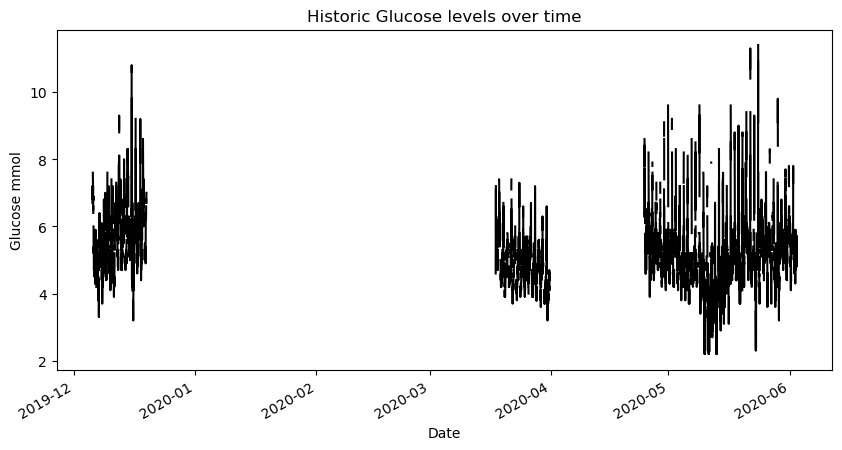

In [14]:
# plot the historc glucose
# To have general ideas about the data
data['Historic_glucose'].plot(color='black', figsize=(10, 5))
plt.title("Historic Glucose levels over time")
plt.xlabel("Date")
plt.ylabel("Glucose mmol")

Text(0, 0.5, 'Glucose mmol')

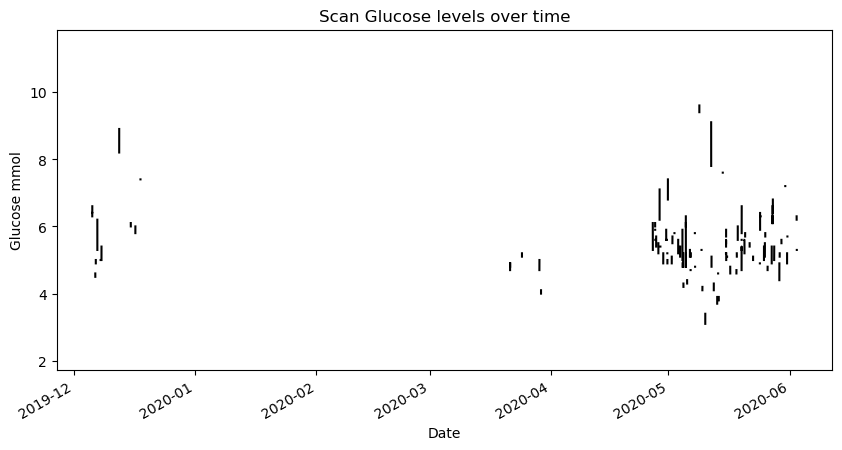

In [15]:
# plot the historc glucose
# To have general ideas about the data
data['Scan_glucose'].plot(color='black', figsize=(10, 5))
plt.title("Scan Glucose levels over time")
plt.xlabel("Date")
plt.ylabel("Glucose mmol")

According to the line plots, data were collected in 3 different period of time, and there are much less points for scan glucose.
Then, create the interactive plot to know more details about the data, and to compare the historoc glucose and scan glucose.

In [16]:
def interactive_plot(df, unit='mmol'):
    dates = np.array(df['Time'], dtype=np.datetime64)
    source = ColumnDataSource(data=dict(date=dates, hist=df['Historic_glucose'], scan=df['Scan_glucose']))

    p = figure(title="Glucose levels over time", height=300, width=800, tools="xpan", toolbar_location=None,
               x_axis_type="datetime", x_axis_location="above",
               background_fill_color="#efefef", x_range=(dates[1500], dates[2500]))

    p.circle('date', 'hist', source=source, color='green', legend_label='Historic')
    p.line('date', 'hist', source=source, color='green', alpha=0.4)
    p.circle('date', 'scan', source=source, color='blue', legend_label='Scan')
    p.line('date', 'scan', source=source, color='blue', alpha=0.4)

    p.yaxis.axis_label = f'Glucose {unit}'

    normal_range = BoxAnnotation(bottom=80, top=180, fill_alpha=0.2, fill_color='#0072B2')

    select = figure(title="Drag the middle and edges of the selection box to change the range above",
                    height=130, width=800, y_range=p.y_range,
                    x_axis_type="datetime", y_axis_type=None,
                    tools="", toolbar_location=None, background_fill_color="#efefef")

    range_tool = RangeTool(x_range=p.x_range)
    range_tool.overlay.fill_color = "navy"
    range_tool.overlay.fill_alpha = 0.2

    select.circle('date', 'hist', source=source, color='green', alpha=0.4)
    select.circle('date', 'scan', source=source, color='blue', alpha=0.4)

    select.ygrid.grid_line_color = None
    select.add_tools(range_tool)

    show(column(p, select))

In [17]:
# Create an interactive bokeh for both historic and scan glucose
# May be able to know more details about the data
# Can see the difference between historic and scan glucose measurements
interactive_plot(glucose_data)

### Imputing ###

In order to find the trend or pattern of this dataset, we impute missing data points with linear interpolation, which add data points according to two neighboring points. It's not appropriate to use fillna() function in this case. Because this function fill missing data points with last observed value, but glucose level fluctuates over time.

In [18]:
imputed_data = glucose_data.interpolate(method='linear')
interactive_plot(imputed_data)

According to the previous plots, we see the gap between '2019-12-20' to '2020-03-17' and '2020-04-01' to '2020-04-24'. Therefore, the data will be split to 3 different sub datasets for further steps.

In [19]:
data = data.sort_index()
#split the data set to 3 sub-datasets according to the 'Time'
#sub1: data recorded from 2019-12-05 to 2019-12-20
#sub2: data recorded from 2020-03-17 to 2020-04-01
#sub3: data recorded from 2020-04-24 to 2020-06-03
sub1 = data['2019-12-05':'2019-12-20']
sub2 = data['2020-03-17':'2020-04-01']
sub3 = data['2020-04-24':'2020-06-03']
sub1.head()

,Historic_glucose,Scan_glucose
Time,,
2019-12-05 15:24:00,NaN,NaN
2019-12-05 16:25:00,6.3,NaN
2019-12-05 16:35:00,NaN,6.3
2019-12-05 16:37:00,NaN,6.4
2019-12-05 16:41:00,6.4,NaN


In [20]:
# Create plots for 3 sub datasets
subsets = ['sub1', 'sub2', 'sub3']
df_dict ={'sub1': sub1,
          'sub2': sub2,
          'sub3': sub3} 

In [21]:
pn.extension()
set_widget = pn.widgets.Select(options=subsets)

@pn.depends(x=set_widget)
def sub_plot(x):
    imputed_data = df_dict[x].interpolate(method='linear')
    dates = np.array(imputed_data.index, dtype=np.datetime64)
    imputed_source = ColumnDataSource(data=dict(date=dates, hist=imputed_data['Historic_glucose'], \
                                                scan=imputed_data['Scan_glucose']))

    p = figure(title="Glucose levels over time", height=300, width=800, tools="xpan", toolbar_location=None,
               x_axis_type="datetime", x_axis_location="above",
               background_fill_color="#efefef", x_range=(dates[0], dates[-1]))

    p.circle('date', 'hist', source=imputed_source, color='green', legend_label='Historic')
    p.line('date', 'hist', source=imputed_source, color='green', alpha=0.4)
    p.circle('date', 'scan', source=imputed_source, color='blue', legend_label='Scan')
    p.line('date', 'scan', source=imputed_source, color='blue', alpha=0.4)

    p.yaxis.axis_label = 'Glucose mmol'

    select = figure(title="Drag the middle and edges of the selection box to change the range above",
                    height=130, width=800, y_range=p.y_range,
                    x_axis_type="datetime", y_axis_type=None,
                    tools="", toolbar_location=None, background_fill_color="#efefef")

    range_tool = RangeTool(x_range=p.x_range)
    range_tool.overlay.fill_color = "navy"
    range_tool.overlay.fill_alpha = 0.2

    select.circle('date', 'hist', source=imputed_source, color='green', alpha=0.4)
    select.circle('date', 'scan', source=imputed_source, color='blue', alpha=0.4)

    select.ygrid.grid_line_color = None
    select.add_tools(range_tool)

    return pn.Column(p, select)

In [22]:
dashboard = pn.Column(set_widget, sub_plot)
dashboard.servable()

Column
    [0] Select(options=['sub1', 'sub2', 'sub3'], value='sub1')
    [1] ParamFunction(function, _pane=Column, defer_load=False)

## Smoothing ##

Compared to the historic glucose, there's much less scan glucose data points. Therefore, from this step, we only use historic glucose data for the further analysis. 

In [23]:
def moving_average(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()

def smoothed_plot(sub_df, window_size, unit='mmol'):
    smoothed_data = moving_average(sub_df, window_size)

    smoothed_data['Historic_glucose'].plot(color='black', figsize=(10, 5))
    plt.title(f"Historic Glucose levels over time")
    plt.xlabel("Date")
    plt.ylabel(f"Glucose {unit}")

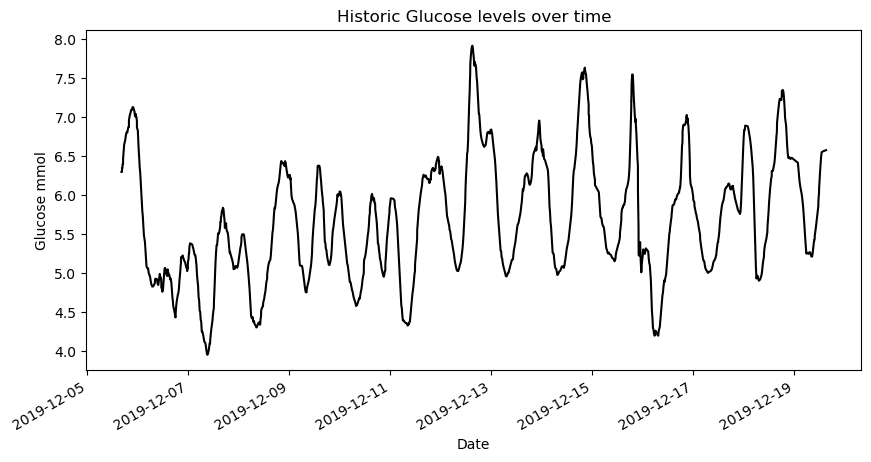

In [24]:
smoothed_plot(sub1, 20)

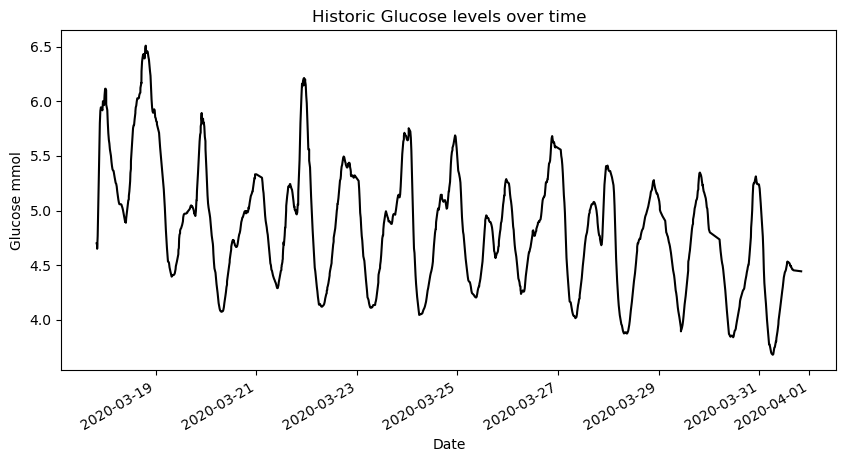

In [25]:
smoothed_plot(sub2, 20)

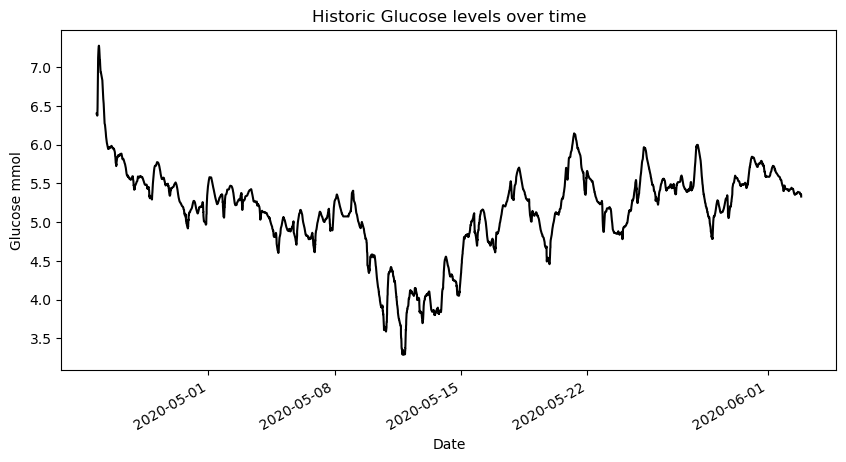

In [26]:
smoothed_plot(sub3, 100)

## Analysis ##

Convert Convert glucose(mmol) to glucose(md/dl).

In [27]:
# Convert glucose(mmol) to glucose(md/dl)
convert_glucose = glucose_data.copy()
convert_glucose['Historic_glucose'] = convert_glucose['Historic_glucose'] * 18.018
convert_glucose['Scan_glucose'] = convert_glucose['Scan_glucose'] * 18.018

In [28]:
interactive_plot(convert_glucose, unit='mg/dl')

According to the plot, historic glucose exceeded 200(mg/dl) or dropped below 50(mg/dl) only between '2020-04-24' and '2020-06-03'.

### Questions ###

Only historic glucose data will be used for further analyses to answer the research questions, because 83.8% of the scan glucose column is null.

#### Question 1 ####
Determine when glucose levels typically reach their highest and lowest points during the day. Identify potential risks; points ≤50 mg/dL to emphasize occurrence of extreme hypoglycemia and points >300 mg/dL to emphasize occurrence of extreme hyperglycemia.

In [29]:
glucose_data.set_index('Time', inplace=True)
glucose_data['Hour'] = glucose_data.index.hour
glucose_data['Historic_glucose'] = glucose_data['Historic_glucose'] * 18.018
glucose_data.head()

,Historic_glucose,Scan_glucose,Hour
Time,,,
2019-12-05 16:25:00,113.5134,NaN,16
2019-12-05 16:41:00,115.3152,NaN,16
2019-12-05 16:56:00,117.1170,NaN,16
2019-12-05 17:11:00,120.7206,NaN,17
2019-12-05 17:26:00,124.3242,NaN,17


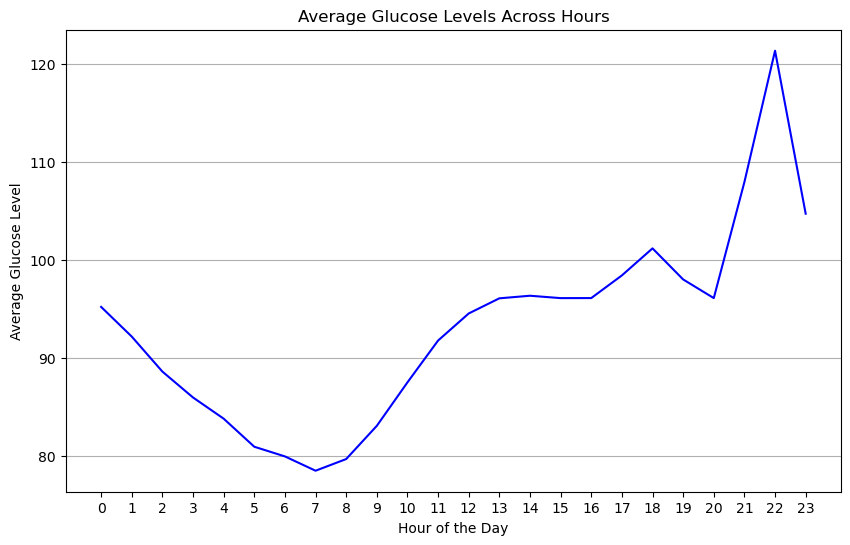

In [30]:
hour_glucose = glucose_data.groupby('Hour')['Historic_glucose'].mean()

#Plot Glucose of each hour
plt.figure(figsize=(10, 6))
hour_glucose.plot(color='blue')
plt.title('Average Glucose Levels Across Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Glucose Level')
plt.xticks(range(24))
plt.grid(axis='y')
plt.show()

In [31]:
hypoglycemia = glucose_data[glucose_data['Historic_glucose'] < 50]
hyperglycemia = glucose_data[glucose_data['Historic_glucose'] > 300]
hypo_hour = hypoglycemia['Hour'].unique().tolist()
hyper_hour = hyperglycemia['Hour'].unique().tolist()
print(hypo_hour)
print(hyper_hour)

[5, 6, 7, 8, 9, 10, 11, 12]
[]


The glucose level reached the highest level at between 10pm to 11pm, and reached lowest level at about 7am. The subject may have the risk of extreme hypoglycemia in the morning, from 5am to 12pm.

#### Question 2 ####

Explore differences in glucose levels across various hours of the day. Investigate the duration between consecutive peaks to understand patterns in glucose level fluctuations

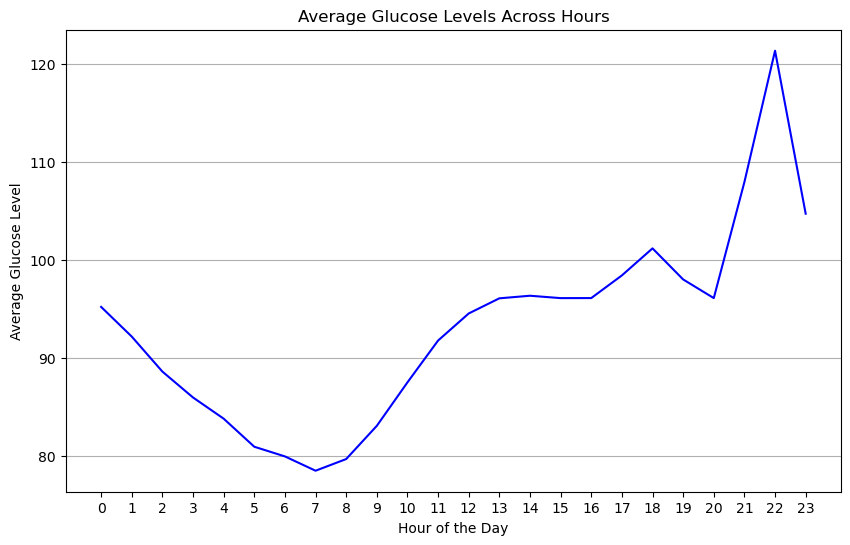

In [32]:
#Plot Glucose of each hour
plt.figure(figsize=(10, 6))
hour_glucose.plot(color='blue')
plt.title('Average Glucose Levels Across Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Glucose Level')
plt.xticks(range(24))
plt.grid(axis='y')
plt.show()

In [33]:
def high_and_low_peaks(data):
    '''
    Find high and low peak points
    data: pandas DataFrame contains target variable
    return:
    high_peaks(list): all the high peak points
    low_peaks(list): all the low peak points
    '''
    high_peaks, _ = find_peaks(data)
    low_peaks, _ = find_peaks(-data)
    return high_peaks, low_peaks

In [34]:
high_peaks, low_peaks = high_and_low_peaks(hour_glucose)
high_hours = hour_glucose.iloc[high_peaks]
low_hours = hour_glucose.iloc[low_peaks]
high_hours

Hour
14     96.364995
18    101.203392
22    121.393646
Name: Historic_glucose, dtype: float64

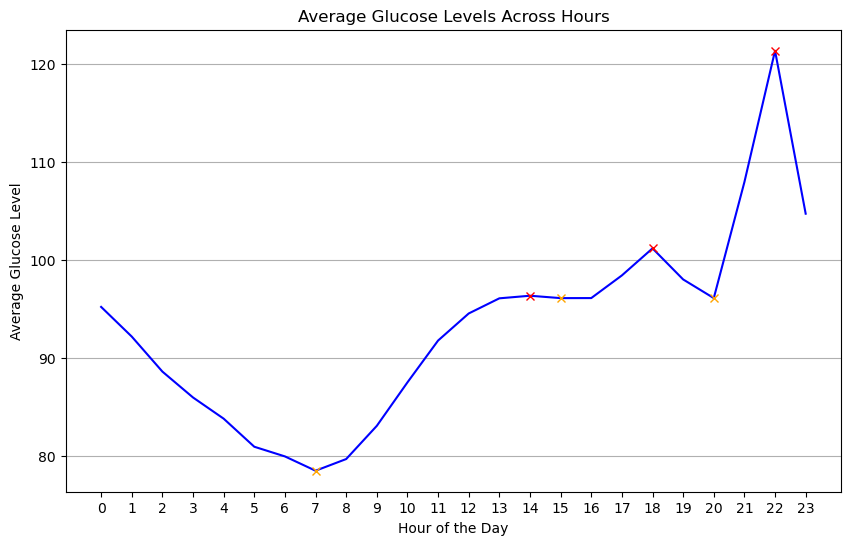

In [35]:
#Plot Glucose of each hour with peak points
plt.figure(figsize=(10, 6))
hour_glucose.plot(color='blue')
plt.plot(high_peaks, high_hours, 'x', color='red')
plt.plot(low_peaks, low_hours, 'x', color='orange')
plt.title('Average Glucose Levels Across Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Glucose Level')
plt.xticks(range(24))
plt.grid(axis='y')
plt.show()

#### Question 3 ####

Stratify the analysis based on weekdays and weekends to capture potential variations.

In [36]:
def day_type(df):
    '''Identify the weekend and weekday and make a new column, "Day_type" '''
    df['Day_type'] = df.index.dayofweek.map(
        {0:'Weekday', 1:'Weekday', 2:'Weekday', 3:'Weekday', 4:'Weekday', 5:'Weekend', 6:'Weekend'})

In [37]:
# Identy the day type of each day
day_type(glucose_data)
glucose_data.head()

,Historic_glucose,Scan_glucose,Hour,Day_type
Time,,,,
2019-12-05 16:25:00,113.5134,NaN,16,Weekday
2019-12-05 16:41:00,115.3152,NaN,16,Weekday
2019-12-05 16:56:00,117.1170,NaN,16,Weekday
2019-12-05 17:11:00,120.7206,NaN,17,Weekday
2019-12-05 17:26:00,124.3242,NaN,17,Weekday


In [38]:
def plot_daytype(df):
    '''Make a plot of glucose over time for weekend and weekdays'''
    hourly_df = df.groupby([df['Hour'], 'Day_type'])['Historic_glucose'].mean().unstack()

    plt.figure(figsize=(10, 6))
    hourly_df.plot(kind='line')
    plt.xlabel('Hour of Day')
    plt.ylabel('Historic glucose mg/dl')
    plt.title('Average Glucose Levels by Hour for Weekdays and Weekends')
    plt.legend(['Weekday', 'Weekend'])
    plt.xticks(range(0, 24))

    plt.show()

<Figure size 1000x600 with 0 Axes>

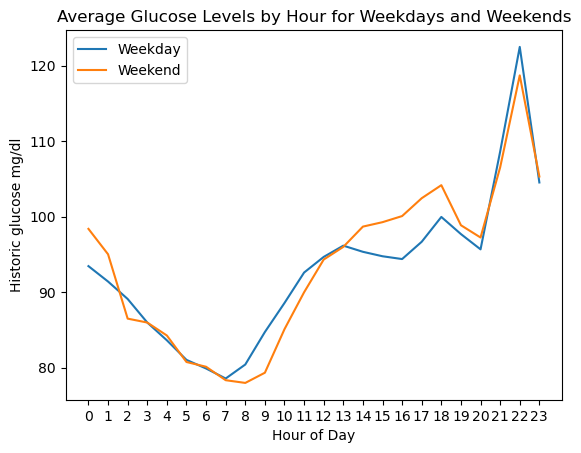

In [39]:
#Compare the historic glucose data for weekend and weekdays
plot_daytype(glucose_data)

In the morning, glucose level starts to increase from 7am in weekdays. However, in weekend glucose level starts to increase from 8am, 1 hour late compared to weekdays.

#### Question 4 ####

Calculate meaningful statistics such as % time spent within target range of 70–180 mg/dL, below 70 mg/dL, and above 180 mg/dL

In [42]:
glucose_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7582 entries, 2019-12-05 16:25:00 to 2020-06-02 13:24:00
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Historic_glucose  6068 non-null   float64
 1   Scan_glucose      1232 non-null   float64
 2   Hour              7582 non-null   int32  
 3   Day_type          7582 non-null   object 
dtypes: float64(2), int32(1), object(1)
memory usage: 266.6+ KB


In [41]:
upper = 180
lower = 70

total_time = glucose_data.index.max() - glucose_data.index.min()
above_range = 
within_range = 
below_range = 

SyntaxError: invalid syntax (3989534082.py, line 5)

#### Question 5 ####

Calculate low glucose events. This defined when the sensor glucose reading is lower than 70 mg/dL for longer than 15 minutes

#### Question 6 ####

Determine if there is a trend